In [65]:
# Import necessary libraries
import pandas as pd
import plotly.graph_objects as go
import dalmatian
from google.cloud import storage
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np

from plotly.subplots import make_subplots
import model_helper 
from helper import *
from plotly_helper import *

In [66]:
# Input patient information
patient_id = 'GCLL-0022'
wbc_file = 'CLL8 CLL cell count 05222025 UPDATED.csv'
treatment_file = 'GCLL_treatment.txt'
UMI_start = 1
UMI_end = 5  
# 
treatment_start = 0


In [67]:
clusters=[1, 2, 3, 4,5,]

In [68]:
# Manually verify the sample list order is correct

In [69]:
sample_list = ['GCLL-0022-T-01','RP-1895_PDO-34670_SM-NPXTD_GCLL-0022-MRD-01_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-33508_SM-NKK13_GCLL-0022-MRD-02_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-34670_SM-NPXSH_GCLL-0022-MRD-03_v1_Custom_Selection_OnPrem','RP-1895_PDO-34670_SM-NPXTL_GCLL-0022-MRD-04_v1_Custom_Selection_OnPrem','GCLL-0022-T-02']

In [70]:
len(sample_list)

6

In [71]:
# Output file

In [72]:
outputfile_name = "CLL_subplot_combined_0022_wbc.html"

In [73]:


# Function to load data
def load_data(patient_id, wbc_file, treatment_file):
    # Load WBC and treatment data
    wbc_df = pd.read_csv(wbc_file)
    treatment_df = pd.read_csv(treatment_file, sep='\t')
    
    # Get input files from Terra through dalmatian
    workspace = 'broad-firecloud-ibmwatson/TAG_CLL_Clonal_Kinetic_UMI_PrAN'
    wm = dalmatian.WorkspaceManager(workspace)
    participants = wm.get_participants()
    
    # Load additional data for the patient
    cluster_CCF_df = pd.read_csv(participants.loc[patient_id]['cluster_ccfs'], sep='\t')
    abundance_df = pd.read_csv(participants.loc[patient_id]['abundances_tsv'], sep='\t')
    mcmc_df = pd.read_csv(participants.loc[patient_id]['cell_population_mcmc_trace'], sep='\t')
    tree_df = pd.read_csv(participants.loc[patient_id]['tree_tsv'], sep='\t')
    
    return wbc_df, treatment_df, cluster_CCF_df, abundance_df, mcmc_df, tree_df

# Function to filter data for a specific patient
def filter_patient_data(wbc_df, patient_id):
    wbc_df_patient = wbc_df[wbc_df['Patient'] == patient_id]
    wbc_df_patient.reset_index(drop=True, inplace=True)
    sample_list = wbc_df_patient['Timepoint'].dropna().tolist()
    times_sample = [int(i) for i in wbc_df_patient.loc[wbc_df_patient.Sample.notna(), 'Time_since_start_tx'].tolist()]
    wbc_all = [float(i) for i in wbc_df_patient['WBC'].tolist()]
    
    
    CLL_count_sample = [float(i) for i in wbc_df_patient.loc[wbc_df_patient.Sample.notna(), 'CLL count estm'].tolist()]
    all_times = [int(i) for i in wbc_df_patient['Time_since_start_tx'].to_list()]
    
    return wbc_df_patient, times_sample, CLL_count_sample, wbc_all,all_times





Update patient specific information in the below cell 

In [74]:
end_treatment_df = pd.read_csv("CLL8_end_treatment.csv")

In [75]:
# Get the treatment duration 

treatment_end = end_treatment_df[end_treatment_df.Patient == patient_id].Treatment_duration.iloc[0]

In [76]:
treatment_end

142

In [77]:

wbc_df, treatment_df, cluster_CCF_df, abundance_df, mcmc_df, tree_df = load_data(patient_id, wbc_file, treatment_file)

# Filter data for the specific patient
wbc_df_patient, times_sample, CLL_count_sample,wbc_count, all_times = filter_patient_data(wbc_df, patient_id)

# Plot CLL count over time and save as HTML
CLL_plot_html = plot_CLL_count(patient_id, times_sample, CLL_count_sample, UMI_start, UMI_end, treatment_start, treatment_end, )
    




In [78]:
times_sample

[-19, 1140, 1211, 1302, 1414, 2029]

In [79]:
wbc_count

[51.88, 3.9, 2.5, 2.8, 3.1, 4.3, 4.1, 4.0, 3.4, 4.1, 5.5, 3.5, 3.4, 2.2]

In [80]:
CLL_count_sample

[46.1732, 0.02983445, 0.06655, 0.08465064, 0.24514, 0.88]

In [81]:
wbc_table_html = plot_metadata_table(wbc_df_patient, patient_id )

In [82]:
def plot_tree(tree_df, tree_selected, ax, edge_labels =None):
    edges = tree_df.loc[tree_selected, 'edges'].split(',')
    cluster_list = []
    for i in edges:
        new_list = i.split('-')
        for j in new_list:
            if (j !='None') & (j not in cluster_list):
                cluster_list.append(j)
    cluster_list = [int(i) for i in cluster_list]


    DG=nx.DiGraph()
    for edge in edges:
        nodes = edge.split('-')
        if nodes[0]!='None':
            DG.add_edge(int(nodes[0]), int(nodes[1]))

    pos=graphviz_layout(DG,  prog='dot')

    edge_color_list=[]
    for edge in DG.edges():
        node=edge[1]

        edge_color_list.append(ClusterColors.get_hex_string(node) )

    nx.draw(DG,pos, with_labels = True, width = 4, node_size= 400, ax =ax, arrows= False, font_color='white',edge_color = edge_color_list, node_color =[ClusterColors.get_hex_string(i) for i in cluster_list] )
    if edge_labels:
        nx.draw_networkx_edge_labels(DG, pos,
        edge_labels,
        font_color=ClusterColors.get_hex_string(7))

    return DG

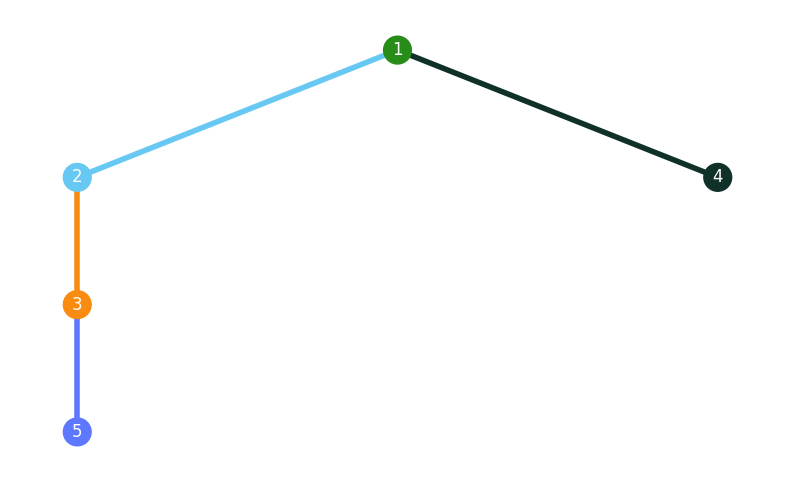

In [83]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_tree(tree_df,0,ax , )

In [84]:
 plot_tree_html = plot_tree_plotly(tree_df, 0)

In [85]:
def plot_ccf(df, times_sample, treatment_df,):
    """
    Plots the CCF (Cancer Cell Fraction) data using Plotly.

    Parameters:
    - df: DataFrame containing CCF data.
    - fig: Plotly figure object.
    - row: Row position of the subplot.
    - col: Column position of the subplot.
    - times_sample: List of sample times.
    - treatment: DataFrame containing treatment information.
    - ClusterColors: Object to map cluster IDs to colors.
    """
    
    
    fig = go.Figure()
    # Keep the necessary columns
    cols = ['Sample_ID', 'Cluster_ID', 'postDP_ccf_mean', 'postDP_ccf_CI_low', 'postDP_ccf_CI_high']
    df = df[cols]
    cluster_list = df.Cluster_ID.unique().tolist()
    number_samples = len(df.Sample_ID.unique())

    # Create tick labels
    tick_list = ['T' + str(i) for i in range(number_samples)]
    x_axis = [i / 365 for i in times_sample]

    # Plot each cluster
    for cluster in cluster_list:
        cluster_data = df[df.Cluster_ID == cluster]
        y_mean = cluster_data.postDP_ccf_mean
        y_ci_low = cluster_data.postDP_ccf_CI_low
        y_ci_high = cluster_data.postDP_ccf_CI_high

        # Plot mean CCF
        fig.add_trace(
            go.Scatter(
                x=x_axis,
                y=y_mean,
                mode='lines+markers',
                line=dict(color=ClusterColors.get_hex_string(cluster)),
                marker=dict(color=ClusterColors.get_hex_string(cluster)),
                name=f'Cluster {cluster}',
                legendgroup=f'Cluster {cluster}'
            ),

        )

        # Plot confidence interval
        fig.add_trace(
            go.Scatter(
                x=x_axis,
                y=y_ci_high,
                mode='lines',
                line=dict(width=0),
                fillcolor=ClusterColors.get_hex_string(cluster),
                fill='tonexty',
                opacity = 0.1,
                showlegend=False,
                legendgroup=f'Cluster {cluster}'
            ),
       
        )
        fig.add_trace(
            go.Scatter(
                x=x_axis,
                y=y_ci_low,
                mode='lines',
                line=dict(width=0),
                fillcolor=ClusterColors.get_hex_string(cluster),
                fill='tonexty',
                opacity = 0.1,
                showlegend=False,
                legendgroup=f'Cluster {cluster}'
            ),
        
        )

    # Add treatment information
    for i, row_data in treatment_df.iterrows():
        treatment_name = row_data.tx
        start = row_data.tx_start / 365
        end = row_data.tx_end / 365 if not np.isnan(row_data.tx_end) else max(x_axis)
        fig.add_vrect(
            x0=start, x1=end,
            fillcolor="lightgray", opacity=0.2,
            layer="below", line_width=0,
            annotation_text=treatment_name, annotation_position="top left"
        )

    # Set axis labels and grid
    fig.update_xaxes(title_text="Samples", )
    fig.update_yaxes(title_text="CCF",)
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', )
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray',)

#     # Add secondary x-axis for time in years
#     fig.update_xaxes(
#         title_text="Time (years)",
        
#         secondary_y=False,
#         overlaying="x",
#         side="top"
        
        
    
#     )
    # Return html content 
    return fig.to_html(full_html=False)

In [86]:
 plot_ccf_html = plot_ccf(cluster_CCF_df, times_sample, treatment_df,)

In [87]:
ccf_tree_html = plot_ccf_tree_combined(
    tree_df=tree_df,
    tree_selected=0,
    ccf_df=cluster_CCF_df,
    times_sample=times_sample,
    treatment_df=treatment_df,

)

In [88]:
CLL_count_sample

[46.1732, 0.02983445, 0.06655, 0.08465064, 0.24514, 0.88]

In [89]:
cluster_list, cluster_abundance = model_helper.get_abundance(abundance_df, mcmc_df, sample_list)
subclone_sample, log_subclone_sample = model_helper.calc_subclone(CLL_count_sample, cluster_abundance, cluster_list)
all_abundance = model_helper.get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

In [90]:
#  Add noise to all abundance

import random 

def add_uniform_noise_and_normalize(lst, low=0, high=0.01):
    
    # Add uniform noise
    noisy_lst = [x + random.uniform(low, high) for x in lst]

    
    # Normalize the list
    total_sum = sum(noisy_lst)
    
    normalized_lst = [x / total_sum for x in noisy_lst]

    return normalized_lst


subclone_cluster_iter = {}
# Iterate through each cluster
for cluster, iterations in all_abundance.items():
   
    # Iterate through each iteration in the cluster
    for iteration, value in iterations.items():
        # If the iteration is not in the new dict, add it
        if iteration not in subclone_cluster_iter:
            subclone_cluster_iter[iteration] = {}
        # Add the cluster and its value to this iteration
        subclone_cluster_iter[iteration][cluster] = value

        
        
noise_added_iter = {}

for iteration, abundances in subclone_cluster_iter.items():
    
    transposed_data = {i: list(values) for i, values in enumerate(zip(*abundances.values()), start=1)}
    
    noise_added_iter[iteration] = {}
    for time_point, abundance in transposed_data.items():
        
#         print(time_point, abundance)
        noise_abundance = add_uniform_noise_and_normalize(abundance)
    
#         print(noise_abundance)

        noise_added_iter[iteration][time_point] = add_uniform_noise_and_normalize(abundance)

    
noise_added_all_abundance = {}
for iteration, abundances in noise_added_iter.items():
    original_format = {i + 1: list(values) for i, values in enumerate(zip(*abundances.values()))}
    noise_added_all_abundance[iteration] = original_format
    
    
noise_added_original_all_abundances = {}

for iteration, abundances in noise_added_all_abundance.items():
    
    for cluster, abundance_value in abundances.items():
        if cluster not in noise_added_original_all_abundances:
            noise_added_original_all_abundances[cluster] = {}
        noise_added_original_all_abundances[cluster][iteration] = abundance_value
            

In [91]:
subclone_sample_mcmc_with_uniform_noise, log_subclone_sample_mcmc_with_uniform_noise = model_helper.calc_subclone(CLL_count_sample, noise_added_original_all_abundances, cluster_list, input_type = "mcmc")

In [92]:
times_aft_tx = [x for x in all_times if x > treatment_end]
times_aft_tx.insert(0, treatment_end)

# Set the extrapolate time after treatment
extrapolate_start_idx = 1

In [93]:
times_sample

[-19, 1140, 1211, 1302, 1414, 2029]

In [94]:
times_aft_tx

[142, 383, 467, 544, 691, 782, 908, 999, 1140, 1211, 1302, 1414, 2029]

In [95]:
# Generate Plotly plot
subclone_plot_html = plot_subclones(cluster_list, times_sample, CLL_count_sample, log_subclone_sample, extrapolate_start_idx, times_aft_tx, treatment_df, treatment_end)


In [96]:
linear_model_mcmc_html = plot_linear_model_mcmc(cluster_list,times_sample,  CLL_count_sample, log_subclone_sample_mcmc_with_uniform_noise,extrapolate_start_idx,times_aft_tx,treatment_df, treatment_end)  

In [97]:
import numpy as np
from scipy.special import logsumexp
from scipy.optimize import minimize
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class MultiClusterLinearRegression:
    def __init__(self, n_clusters, X, y):
        """
        Initialize the multi-cluster linear regression model.

        Parameters:
        - n_clusters: Number of clusters.
        - X: Input features (1D array of shape (n_samples,)).
        - y: Target values (1D array of shape (n_samples,)). None values indicate missing data.
        """
        self.n_clusters = n_clusters
        self.params = None
        self.X = X
        self.y = y

    def calculate_weight_ratio(self):
        """
        Calculate the weight ratio for balancing exome and wbc contributions.

        Returns:
        - weight_ratio: Ratio of WBC counts to exome counts.
        """
        num_wbc = len(self.y)
        num_exomes = sum(1 for item in self.y if item is not None)
        weight_ratio = num_wbc / ((num_exomes) * (self.n_clusters - 1))
        return weight_ratio

    def objective(self, params, logsumexp_points):
        """
        Objective function to minimize for fitting the model.

        Parameters:
        - params: Model parameters (intercepts and slopes).
        - logsumexp_points: Logsumexp target values (1D array of shape (n_samples,)). None values indicate missing data.

        Returns:
        - Negative log-likelihood to minimize.
        """
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]

        # Calculate predicted y values for all clusters
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calculate negative log-likelihood
        likelihood = 0

        # For exome points
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood += self.calculate_weight_ratio() * np.sum((yi - y_pred[i]) ** 2)

        # For logsumexp points
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood += (lse - logsumexp(y_pred[i])) ** 2

        return likelihood  # Minimize negative log-likelihood

    def fit(self, logsumexp_points, initial_guess=None):
        """
        Fit the model to the data.

        Parameters:
        - logsumexp_points: Logsumexp target values (1D array of shape (n_samples,)). None values indicate missing data.
        - initial_guess: Initial guess for model parameters. If None, random values are used.
        """
        if initial_guess is None:
            initial_guess = np.random.randn(2 * self.n_clusters)

        result = minimize(
            self.objective,
            initial_guess,
            args=(logsumexp_points),
            method='SLSQP'
        )

        self.params = result.x

    def calculate_likelihood(self, params, logsumexp_points):
        """
        Calculate the likelihood components for debugging or analysis.

        Parameters:
        - params: Model parameters (intercepts and slopes).
        - logsumexp_points: Logsumexp target values (1D array of shape (n_samples,)). None values indicate missing data.

        Returns:
        - likelihood_y: Likelihood contribution from exome points.
        - likelihood_logsumexp: Likelihood contribution from logsumexp points.
        """
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calculate likelihood for exome points
        likelihood_y = 0
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood_y += np.sum((yi - y_pred[i]) ** 2)
                logger.info(f"Exome logsubclone: {yi}, Exome predicted: {y_pred[i]}, Likelihood_y: {likelihood_y}")

        logger.info(f"Squared sum_y: {likelihood_y}")

        # Calculate likelihood for logsumexp points
        likelihood_logsumexp = 0
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood_logsumexp += (lse - logsumexp(y_pred[i])) ** 2
                logger.info(f"Log WBC: {lse}, WBC predicted: {logsumexp(y_pred[i])}")

        logger.info(f"Squared sum_logsumexp: {likelihood_logsumexp}")

        total_squared_sum = likelihood_y + likelihood_logsumexp
        logger.info(f"Total squared sum: {total_squared_sum}")

        return likelihood_y, likelihood_logsumexp

    def predict(self, x_to_predict):
        """
        Predict target values using the fitted model.

        Returns:
        - Predicted values for all clusters (2D array of shape (n_samples, n_clusters)).
        """
        if self.params is None:
            raise ValueError("Model has not been fitted yet. Call `fit` first.")

        intercepts = self.params[:self.n_clusters]
        slopes = self.params[self.n_clusters:]
        return np.outer(x_to_predict, slopes) + intercepts

In [98]:


def create_inputs(times_sliced, log_subclone_sample_mcmc, iter, index_samples_model):
    """
    Create input features (X) and target values (y) for the model.

    Parameters:
    - times_sliced: List of time points (in days).
    - log_subclone_sample_mcmc: Dictionary of subclone data in the format {cluster: {iteration: [values]}}.
    - iter: The iteration number to use for extracting values.
    - index_samples_model: Indices of the samples to include in the target values.

    Returns:
    - X: Input features (time in years).
    - y: Target values (list with None for missing data).
    """
    # Convert times to years
    X = [t / 365 for t in times_sliced]

    # Reconstruct the dictionary to {iteration: {cluster: [values]}}
    log_subclone_cluster_iter = reconstruct_log_subclone_dict(log_subclone_sample_mcmc)

    # Extract values for the specified iteration
    values = list(log_subclone_cluster_iter[iter].values())
    array = np.array(values).T  # Transpose to match the desired shape

    # Select the samples corresponding to the specified indices
    selected_sample = array[index_samples_model]

    # Map the selected samples to the correct positions in y
    y = map_samples_to_y(times_sliced, times_sample[index_samples_model], selected_sample)

    return X, y


def reconstruct_log_subclone_dict(log_subclone_sample_mcmc):
    """
    Reconstruct the log_subclone_sample_mcmc dictionary to {iteration: {cluster: [values]}}.

    Parameters:
    - log_subclone_sample_mcmc: Dictionary of subclone data in the format {cluster: {iteration: [values]}}.

    Returns:
    - log_subclone_cluster_iter: Reconstructed dictionary.
    """
    log_subclone_cluster_iter = {}
    for cluster, iterations in log_subclone_sample_mcmc.items():
        for iteration, value in iterations.items():
            if iteration not in log_subclone_cluster_iter:
                log_subclone_cluster_iter[iteration] = {}
            log_subclone_cluster_iter[iteration][cluster] = value
    return log_subclone_cluster_iter


def map_samples_to_y(times_sliced, times_sample_selected, selected_sample):
    """
    Map the selected samples to the correct positions in y.

    Parameters:
    - times_sliced: List of time points (in days).
    - times_sample_selected: List of selected time points (in days).
    - selected_sample: List of values corresponding to the selected time points.

    Returns:
    - y: List with values at the correct positions and None elsewhere.
    """
    y = [None] * len(times_sliced)
    indices = [i for i, t in enumerate(times_sliced) if t in times_sample_selected]

    for idx, sample_idx in enumerate(indices):
        y[sample_idx] = selected_sample[idx]

    return y

In [99]:
# Convert the column "CLL count estm" to float 
wbc_df_patient['CLL count estm'] = wbc_df_patient['CLL count estm'].astype(float) 
times_sliced_aft = [int(i) for i in wbc_df_patient[wbc_df_patient['CLL count estm'] > 0]['Time_since_start_tx'].values  if int(i) > 0]

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_30826/981427378.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
times_aft_tx

[142, 383, 467, 544, 691, 782, 908, 999, 1140, 1211, 1302, 1414, 2029]

In [101]:
# Needs to manually check times_sliced_aft

In [102]:
times_sliced_aft

[467, 691, 782, 908, 999, 1140, 1211, 1302, 1414, 2029]

In [103]:
len(times_sliced_aft)

10

In [104]:
index_samples_model = slice(1,6)

# index_samples_model is the index of the samples after treatment. For instance, slice(1,7) means sample 2, 3, 4, 5,6, 7

X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,2, index_samples_model)



In [105]:
log_subclone_sample_mcmc_with_uniform_noise[1][2]

[2.7096578189018534,
 -4.839077714251823,
 -4.145323125501771,
 -7.004640960219437,
 -8.681186422140689,
 -8.741752570152945]

In [106]:
y

[None,
 None,
 None,
 None,
 None,
 array([-4.83907771, -5.05123539, -4.77293463, -5.06127946, -7.20802117]),
 array([-4.14532313, -3.36013331, -4.45394805, -5.60033479, -7.2858686 ]),
 array([-7.00464096, -2.77009879, -5.25128508, -4.22430174, -6.68208594]),
 array([-8.68118642, -1.65000588, -3.87787116, -4.44316626, -3.88292265]),
 array([-8.74175257, -0.92492277, -0.89723284, -4.4451113 , -2.74441151])]

In [107]:
wbc_aft_tx = wbc_df_patient[wbc_df_patient.Time_since_start_tx > treatment_end]['CLL count estm'].to_list()
wbc_model = [i for i in wbc_aft_tx if i > 0]

In [108]:
wbc_model

[0.00029033,
 0.00257116,
 0.00374381,
 0.00645212,
 0.0114789,
 0.02983445,
 0.06655,
 0.08465064,
 0.24514,
 0.88]

In [109]:
len(wbc_model)

10

In [110]:
n_clusters = len(cluster_list)
logsumexp_points = np.log(wbc_model)
model = MultiClusterLinearRegression(n_clusters, X, y)
model.fit(logsumexp_points)

In [111]:
for i in zip(times_sliced_aft, wbc_model):
    print(i)

(467, 0.00029033)
(691, 0.00257116)
(782, 0.00374381)
(908, 0.00645212)
(999, 0.0114789)
(1140, 0.02983445)
(1211, 0.06655)
(1302, 0.08465064)
(1414, 0.24514)
(2029, 0.88)


In [112]:
def plot_subclones_new_model(clusters, times_sample, CLL_count, log_subclone_sample, extrapolate_start_idx, times_aft_tx, times_sliced_aft, treatment,model ):
    """
    Plot subclones and extrapolate their behavior after treatment using Plotly.

    Args:
        clusters (list): List of cluster IDs to plot.
        times_sample (list): List of timepoints since treatment start.
        CLL_count (list): List of CLL count estimates.
        log_subclone_sample (dict): Dictionary of log subclone counts for each cluster.
        extrapolate_start_idx (int): Index to start extrapolation.
        times_aft_tx (list): Timepoints after treatment for extrapolation.
        treatment (pd.DataFrame): Treatment data.
        ClusterColors: Object to get cluster colors.
    """
    # Create a subplot with two rows
    fig = go.Figure()

    # Plot total WBC
    x_year = [i / 365 for i in np.array(times_sample)]
    x_year_selected = [ i/365 for i in np.array(times_sliced_aft)]
    fig.add_trace(
        go.Scatter(x= x_year_selected, y=np.log(wbc_model), mode='markers', name='CLL count estimate', marker=dict(color='red')),
        
    )

    # Plot subclones and extrapolate after treatment
    predicted_end_tx_clones = []
    for i in clusters:
        y_sub = np.array(log_subclone_sample[i])
        fig.add_trace(
            go.Scatter(x=x_year, y=y_sub, mode='markers', name=f'Cluster {i}', marker=dict(color=ClusterColors.get_hex_string(i))),
           
        )

        # Extrapolate after treatment
        extrapolate_times = times_sample[extrapolate_start_idx:]
        extrapolate_year = [i / 365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]

        # Fit a linear model for extrapolation
        linear_model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)
        predict_year = [i / 365 for i in np.array(times_aft_tx)]
        predicted = np.polyval(linear_model, predict_year)
        predicted_end_tx_clones.append(predicted[0])

        # Plot the extrapolated line
        fig.add_trace(
            go.Scatter(x=predict_year, y=predicted, mode='lines', name=f'Cluster {i} (extrapolated)', line=dict(color=ClusterColors.get_hex_string(i))),
            
        )
        
        # Plot predicted values
        times_aft_tx_year = [i/365 for i in times_aft_tx]
        fig.add_trace(go.Scatter(
            x=times_aft_tx_year,
            y=model.predict(times_aft_tx_year)[:, i - 1],
            mode='lines',
            line=dict(dash='dash', color=ClusterColors.get_hex_string(i)),
            name=f'Cluster {i} (Predicted)'
        ), )
        
        
        # Plot logsumexp points
        logsumexp_points_model = [logsumexp(yi) for yi in model.predict(times_aft_tx_year)]
        fig.add_trace(go.Scatter(
            x=times_aft_tx_year[1:],
            y=logsumexp_points_model[1:],
            mode='markers',
            marker=dict(symbol='triangle-up', color='grey', opacity=0.5),
            showlegend=False
        ), )

    # Plot treatment effects
    times_during_tx = [0, treatment_end / 365]
    tx_start_clones = [log_subclone_sample[i][0] for i in clusters]

    

    # Add treatment annotations
    for i, row in treatment_df.iterrows():
        treatment_name = row.tx
        start = row.tx_start / 365
        end = treatment_end/365
        fig.add_vrect(x0=start, x1=end, fillcolor="lightgray", opacity=0.5, line_width=0, annotation_text=treatment_name, annotation_position="top left", )

    # Update layout
    fig.update_layout(
        title="Subclonal analyis with added wbc estimations",
        xaxis_title="Time (years)",
        yaxis_title="log CLL count estimates",

        showlegend=True,
        height=800,
    )

    # Return HTML content
    return fig.to_html(full_html=False)
    


   

In [113]:
# Generate Plotly plot
subclone_plot_new_model_html = plot_subclones_new_model(cluster_list, times_sample, CLL_count_sample, log_subclone_sample, extrapolate_start_idx, times_aft_tx, times_sliced_aft, treatment_df,model )


In [117]:
def plot_mcmc_model(clusters, index_samples_model, times_aft_tx, times_sliced_aft):
    """
    Plot MCMC models for each cluster dynamically and save the figure as an HTML file.

    Parameters:
        clusters (list): List of cluster indices to plot.
        index_samples_model (slice): Slice object for indexing samples.
    """
    # Determine the number of rows and columns
    num_clusters = len(clusters)
    num_rows = (num_clusters + 1)// 2 + 3  # Ensure enough rows for clusters and histogram
    num_cols = 2  # Two columns 
    
    
    # Define subplot specs
    specs = []
    # Add rows for cluster plots
    for _ in range((num_clusters + 1) // 2):
        specs.append([{'type': 'xy'}, {'type': 'xy'}])
    # Add row for histograms
    specs.append([{'type': 'xy'}, {'type': 'xy'}])
    # Add rows for tables
    specs.append([{'type': 'table', 'colspan': 2}, None])  # Growth table
    specs.append([{'type': 'table', 'colspan': 2}, None])  # Decay table
    

    # Create a subplot with dynamic rows and 2 columns
    fig = make_subplots(
        rows=num_rows, cols=num_cols,
        subplot_titles=(
            [f"MCMC Model Cluster {cluster}" for cluster in clusters] + ([""] if len(clusters) % 2 == 1 else []) +
            ["Growth Rate Histogram"] + ['Decay Rate Histogram'] 
            
            
        ),
        specs=specs,
        vertical_spacing=0.1,
        row_heights=[1] * ((num_clusters + 1) // 2) + [1, 0.5, 0.5]  # Adjust table row heights
    )

    # Define the number of ticks and tick labels
    tick_num = len(sample_list)
    tick_list = ['T' + str(i) for i in range(tick_num)]

    # Dictionary to store slopes
    slopes_mcmc = {}
    
    slopes_mcmc_decay = {}

    # Loop through each cluster and plot MCMC models
    for idx, cluster in enumerate(clusters, start=1):
        row = (idx - 1) // 2 + 1  # Start from row 1
        col = (idx - 1) % 2 + 1   # Alternate between columns 1 and 2

        # Plot total WBC
        x_year_selected = [i / 365 for i in np.array(times_sliced_aft)]
        fig.add_trace(go.Scatter(
            x=x_year_selected,
            y=np.log(wbc_model),
            mode='markers',
            marker=dict(color='red'),
            name='CLL count estimate'
        ), row=row, col=col)
        
        
        slopes_mcmc_decay[cluster] = []
        slopes_mcmc[cluster] = []

        # Plot subclones and MCMC iterations
        for iter_idx in range(250):
            x_year = [i / 365 for i in np.array(times_sample)][1:]
            y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])[1:]
            fig.add_trace(go.Scatter(
                x=x_year,
                y=y_sub,
                mode='markers',
                marker=dict(color=ClusterColors.get_hex_string(cluster), opacity=0.5),
                showlegend=False
            ), row=row, col=col)

            # Create inputs and fit the model
            X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise, iter_idx, index_samples_model)
            logsumexp_points = np.log(wbc_model)
            model = MultiClusterLinearRegression(num_clusters, X, y)
            model.fit(logsumexp_points)

            # Store slopes
            cluster_slopes = model.params[num_clusters:]
            slopes_mcmc[cluster].append(cluster_slopes)
            
            times_aft_tx_year = [i/365 for i in times_aft_tx]
            # Calculate decay rate
            predicted = model.predict(times_aft_tx_year)[:, cluster - 1]
            
            slope_decay = (predicted[0] - y_sub[0]) / (treatment_end / 365)
            slopes_mcmc_decay[cluster].append(slope_decay)
            
            # Plot during treatment
            times_during_tx = [0, treatment_end / 365]
            tx_start_clones = y_sub[0]
            fig.add_trace(
                go.Scatter(
                    x=times_during_tx,
                    y=[tx_start_clones, predicted[0]],
                    mode='lines+markers',
                    line=dict(color=ClusterColors.get_hex_string(cluster)),
                    marker=dict(color=ClusterColors.get_hex_string(cluster)),
                    showlegend=False
                ),
                row=row, col=col
            )

            # Plot predicted values
            times_aft_tx_year = [i/365 for i in times_aft_tx]
            fig.add_trace(go.Scatter(
                x=times_aft_tx_year,
                y=model.predict(times_aft_tx_year)[:, cluster - 1],
                mode='lines',
                line=dict(dash='dash', color=ClusterColors.get_hex_string(cluster)),
                showlegend=False
            ), row=row, col=col)

            # Plot logsumexp points
            logsumexp_points_model = [logsumexp(yi) for yi in model.predict(times_aft_tx_year)]
            fig.add_trace(go.Scatter(
                x=times_aft_tx_year[1:],
                y=logsumexp_points_model[1:],
                mode='markers',
                marker=dict(symbol='triangle-up', color='grey', opacity=0.5),
                showlegend=False
            ), row=row, col=col)

#         # Add secondary x-axis
#         x_axis = [i / 365 for i in times_sample]
#         fig.update_xaxes(tickvals=x_axis, ticktext=tick_list, row=row, col=col)
#         fig.update_xaxes(title_text="Time (years)", row=row, col=col, secondary_y=True)

        # Add grid and labels
        fig.update_xaxes(showgrid=True, row=row, col=col)
        fig.update_yaxes(title_text="log WBC × 10^6 cells per ml", row=row, col=col)
        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', row=row, col=col)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', row=row, col=col)

        # Add treatment annotations
        for i, row_data in treatment_df.iterrows():
            treatment_name = row_data.tx
            start = row_data.tx_start / 365
            end = treatment_end / 365
            if np.isnan(end):
                end = x_axis[-1]
            fig.add_vrect(
                x0=start, x1=end,
                fillcolor="grey",opacity = 0.5,
                layer="below",
                line_width=0,
                annotation_text=treatment_name,
                annotation_position="top left",
                row=row, col=col
            )

    row_hist = num_rows-2
    # Plot histogram of slopes in the second last row
    for cluster in clusters:
        cluster_slopes_array = np.array(slopes_mcmc[cluster])
        if cluster_slopes_array.ndim > 1:
            # If slopes are multi-dimensional, take the appropriate dimension
            cluster_slopes_flat = cluster_slopes_array[:, cluster - 1] if cluster_slopes_array.shape[1] >= cluster else cluster_slopes_array.flatten()
        else:
            cluster_slopes_flat = cluster_slopes_array
            
        fig.add_trace(go.Histogram(
            x=cluster_slopes_flat,
            name=f'Cluster {cluster}',
            marker_color=ClusterColors.get_hex_string(cluster),
            opacity=0.5,
        ), row=row_hist, col=1)
    
    for cluster in clusters:
        fig.add_trace(
            go.Histogram(
                x=slopes_mcmc_decay[cluster],
                name=f'Cluster {cluster} Decay',
                marker_color=ClusterColors.get_hex_string(cluster),
                opacity=0.5
            ),
            row=row_hist, col=2
        )
    
        
     # Calculate stats for growth rates
    table_data_growth = []
    for cluster in clusters:
        cluster_slopes_array = np.array(slopes_mcmc[cluster])
        if cluster_slopes_array.ndim > 1:
            cluster_slopes_flat = cluster_slopes_array[:, cluster - 1] if cluster_slopes_array.shape[1] >= cluster else cluster_slopes_array.flatten()
        else:
            cluster_slopes_flat = cluster_slopes_array
            
        mean = np.mean(cluster_slopes_flat)
        lower_ci = np.percentile(cluster_slopes_flat, 2.5)
        upper_ci = np.percentile(cluster_slopes_flat, 97.5)
        table_data_growth.append([f'Cluster {cluster}', f'{mean:.4f}', f'{lower_ci:.4f} to {upper_ci:.4f}'])
    
    # Calculate stats for decay rates
    table_data_decay = []
    for cluster in clusters:
        mean_decay = np.mean(slopes_mcmc_decay[cluster])
        lower_ci_decay = np.percentile(slopes_mcmc_decay[cluster], 2.5)
        upper_ci_decay = np.percentile(slopes_mcmc_decay[cluster], 97.5)
        table_data_decay.append([f'Cluster {cluster}', f'{mean_decay:.4f}', f'{lower_ci_decay:.4f} to {upper_ci_decay:.4f}'])

 
    # Add growth rate table 
    fig.add_trace(
        go.Table(
            header=dict(
                values=['Cluster', 'Mean Growth Rate', '95% CI'],
                fill_color='lightblue',
                align='left'
            ),
            cells=dict(
                values=list(zip(*table_data_growth)),
                fill_color='white',
                align='left'
            )
        ),
        row=num_rows -1, col=1
    )
    
    
        # Add decay rate table (last row)
    fig.add_trace(
        go.Table(
            header=dict(
                values=['Cluster', 'Mean Decay Rate', '95% CI'],
                fill_color='lightgreen',
                align='left'
            ),
            cells=dict(
                values=list(zip(*table_data_decay)),
                fill_color='white',
                align='left'
            )
        ),
        row=num_rows, col = 1)
    
    fig.update_xaxes(title_text="Growth Rate (slope)", row=row_hist, col=1)
    fig.update_yaxes(title_text="Count", row=row_hist, col=1)

    # Add axis labels for decay histogram  
    fig.update_xaxes(title_text="Decay Rate (slope)", row=row_hist, col=2)
    fig.update_yaxes(title_text="Count", row=row_hist, col=2)
    
    # Update layout
    fig.update_layout(
        title_text="MCMC Model Analysis",
        showlegend=True,
#         width=1200,
        height=400 * num_rows  # Adjust height dynamically based on the number of rows
    )

    # Return HTML content
    return fig.to_html(full_html=False)

In [118]:
plot_mcmc_new_model_html = plot_mcmc_model(clusters, index_samples_model, times_aft_tx,times_sliced_aft)


In [119]:
create_html_file([wbc_table_html, plot_ccf_html, ccf_tree_html, CLL_plot_html, subclone_plot_html,linear_model_mcmc_html,subclone_plot_new_model_html, plot_mcmc_new_model_html], output_file=outputfile_name)

HTML file saved as CLL_subplot_combined_0022_wbc.html
